## Phase Diagram and Out-of-Equilibrium Dynamics

Author: Roman Aseguinolaza Gallo

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import tenpy
from tenpy.algorithms import dmrg, tebd
from tenpy.networks.mps import MPS
from tenpy.models.spins_nnn import SpinChainNNN

import warnings
warnings.filterwarnings("ignore", message="unused option", category=UserWarning)


---
### I. INTRODUCTION

We will study the phase diagram and the out-of-equilibrium dynamics of a paradigmatic spin model. The model is defined on an open chain of spin-1/2 constituents of length $ L $. The Hamiltonian is given by [1]:

\begin{equation*}
H(p, \lambda) = - \sum_i \left[ \sigma_i^z \sigma_{i+1}^z + \lambda \sigma_i^x + p (\sigma_i^z \sigma_{i+2}^z + \lambda \sigma_i^x \sigma_{i+1}^x ) \right].
\end{equation*}

**Key properties of the Hamiltonian:**

1. If $ p = 0 $, the model reduces to the standard transverse-field Ising model.

2. If $ \lambda = 1 $ and $ p \to \infty $, the Ising part becomes negligible, and the model is more complicated.

3. For $ p \neq 0 $, the Hamiltonian includes next-nearest-neighbor interactions.

The goal of this assignment is to analyze the phase diagram of the model in the $ (p, \lambda) $ plane and to study its out-of-equilibrium dynamics. We will focus on values $ p \leq 1 $ to stay close to the transverse field Ising model (whose properties you can obtain by setting $ p = 0 $).

---
### II. PHASE DIAGRAM

Using **TeNPy** [2,3], perform the following tasks:

1. **Define the model in TeNPy**

2. **Characterize the phase diagram using an infinite MPS ansatz**

   (a) For each $(p, \lambda)$ point, run simulations with bond dimensions $D = 16$ and $D = 32$.

   (b) Compute and plot the correlation length $\xi$ as a function of $p$ and $\lambda$ for both bond dimensions.

3. **Extend simulations to larger bond dimensions** $(D \leq 64)$

   (a) Identify regions where $\xi$ saturates with $D$ versus where it continues to grow.

   (b) Plot the half-chain entanglement entropy $S(\xi(D))$ versus $D$ [4].

In [2]:
def H_model(spin,lmbd,p):
  
    model_params = dict(L=2, S=spin, Jy=0, Jz=-4, hx=lmbd*2, hy=0, hz=0, Jxp=0, Jyp=0, Jzp=-p*4, Jx=-p*lmbd*4, bc_MPS ='infinite', conserve = 'None')
    M = SpinChainNNN(model_params)
    
    psi = MPS.from_lat_product_state(M.lat, [['up_0 up_1']])

    return M, psi


In [ ]:
def run_dmrg(M,psi,chi_max,max_sweeps):
  
    dmrg_params = {
        'mixer': None, # setting this to True helps to escape local minima
        'max_E_err': 1.e-10,
        'max_sweeps': max_sweeps,
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-10,
        },
        'verbose': True,
        'combine': True
    }
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)

    E, psi = eng.run() # the main work; modifies psi in place
    
    return E


In [ ]:
''' Standard transverse-field Ising model with bond dimension D = 16 '''

spin = 0.5
D = 16

p = 0
lmbd = np.linspace(0,2,21)
E_p0_16 = np.zeros(len(lmbd))
corr_lenght_p0_16 = np.zeros(len(lmbd))

for i in range(len(lmbd)):
  M, psi = H_model(spin, lmbd[i], p)
  E_p0_16[i] = run_dmrg(M, psi, D, 10)
  corr_lenght_p0_16[i] = psi.correlation_length()


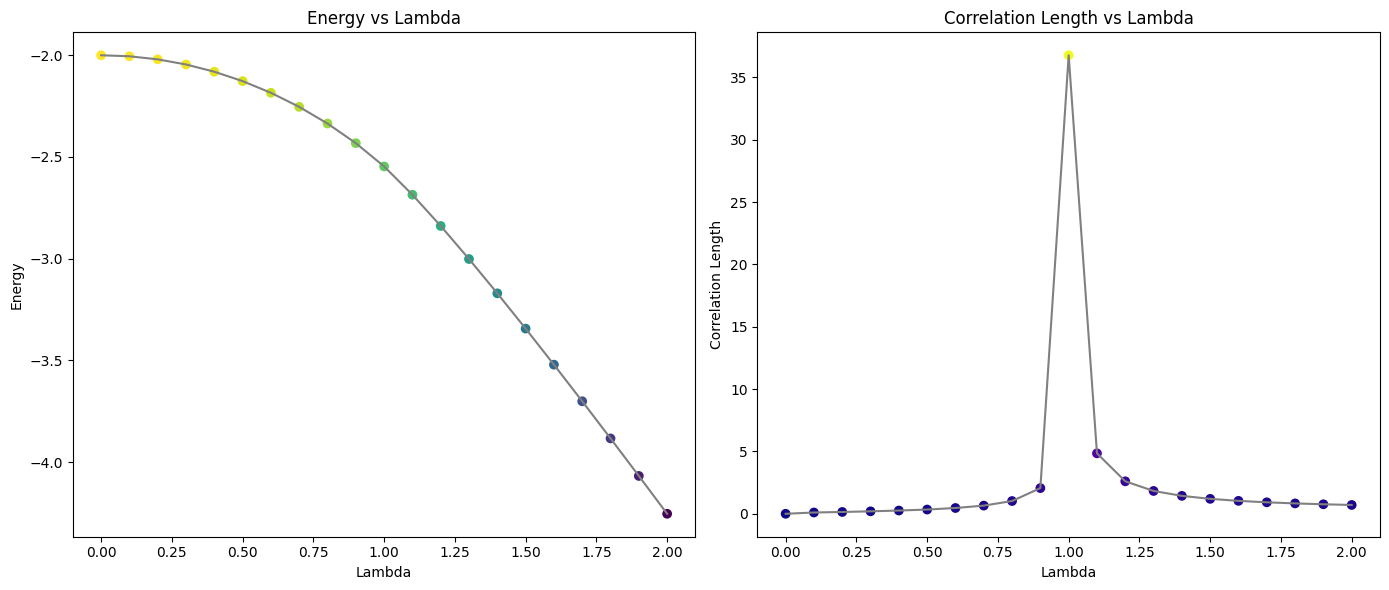

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Normalize the data for color mapping
norm_energy = plt.Normalize(E_p0_16.min(), E_p0_16.max())
norm_corr = plt.Normalize(corr_lenght_p0_16.min(), corr_lenght_p0_16.max())

# Plot Energy vs Lambda with viridis color palette
sc1 = ax1.scatter(lmbd, E_p0_16, c=E_p0_16, cmap='viridis', norm=norm_energy, marker='o')
ax1.plot(lmbd, E_p0_16, linestyle='-', color='gray')  # Add line connecting the dots
ax1.set_title('Energy vs Lambda')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Energy')
# fig.colorbar(sc1, ax=ax1, label='Energy')

# Plot Correlation Length vs Lambda with plasma color palette
sc2 = ax2.scatter(lmbd, corr_lenght_p0_16, c=corr_lenght_p0_16, cmap='plasma', norm=norm_corr, marker='o')
ax2.plot(lmbd, corr_lenght_p0_16, linestyle='-', color='gray')  # Add line connecting the dots
ax2.set_title('Correlation Length vs Lambda')
ax2.set_xlabel('Lambda')
ax2.set_ylabel('Correlation Length')
# fig.colorbar(sc2, ax=ax2, label='Correlation Length')

plt.tight_layout()
plt.show()


In [12]:
# Print the available state keys for each site in psi

for i, site in enumerate(psi.sites):
    keys = list(site.state_labels.keys())
    print(f"Site {i} available state keys: {keys}")


Site 0 available state keys: ['-0.5_0 -0.5_1', '-0.5_0 0.5_1', '-0.5_0 down_1', '-0.5_0 up_1', '0.5_0 -0.5_1', '0.5_0 0.5_1', '0.5_0 down_1', '0.5_0 up_1', 'down_0 -0.5_1', 'down_0 0.5_1', 'down_0 down_1', 'down_0 up_1', 'up_0 -0.5_1', 'up_0 0.5_1', 'up_0 down_1', 'up_0 up_1']
Site 1 available state keys: ['-0.5_0 -0.5_1', '-0.5_0 0.5_1', '-0.5_0 down_1', '-0.5_0 up_1', '0.5_0 -0.5_1', '0.5_0 0.5_1', '0.5_0 down_1', '0.5_0 up_1', 'down_0 -0.5_1', 'down_0 0.5_1', 'down_0 down_1', 'down_0 up_1', 'up_0 -0.5_1', 'up_0 0.5_1', 'up_0 down_1', 'up_0 up_1']


In [ ]:
''' Full Hamiltonian with bond dimension D = 16 '''

spin = 0.5
D = 16

p = np.linspace(0,1,11)
lmbd = np.linspace(0,2,21)
E_16 = np.zeros((len(p),len(lmbd)))
corr_lenght_16 = np.zeros((len(p),len(lmbd)))

for j in range(len(p)):
    print(f"Running DMRG for p = {p}")
    for i in range(len(lmbd)):
        M, psi = H_model(spin, lmbd[i], p[j])
        E_16[j, i] = run_dmrg(M, psi, D, 20)
        corr_lenght_16[j, i] = psi.correlation_length()


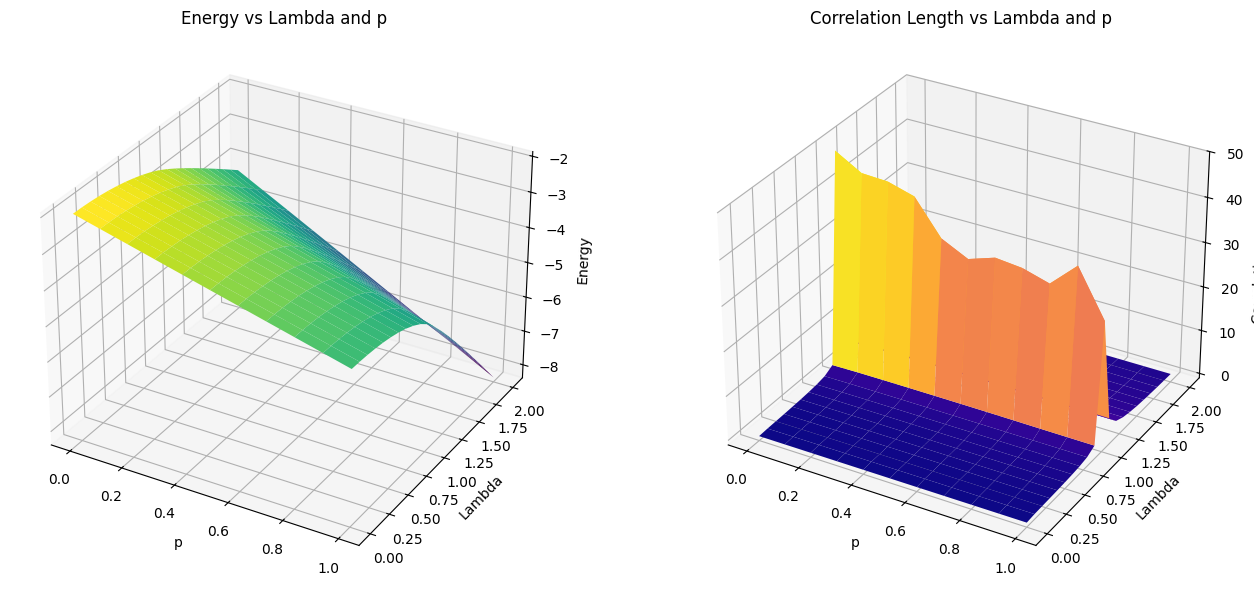

In [14]:
fig = plt.figure(figsize=(14, 6))

# 3D Plot for Energy
ax1 = fig.add_subplot(121, projection='3d')
P, L = np.meshgrid(p, lmbd)
ax1.plot_surface(P, L, E_16.T, cmap='viridis')
ax1.set_title('Energy vs Lambda and p')
ax1.set_xlabel('p')
ax1.set_ylabel('Lambda')
ax1.set_zlabel('Energy')

# 3D Plot for Correlation Length
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(P, L, corr_lenght_16.T, cmap='plasma')
ax2.set_title('Correlation Length vs Lambda and p')
ax2.set_xlabel('p')
ax2.set_ylabel('Lambda')
ax2.set_zlabel('Correlation Length')

plt.tight_layout()
plt.show()


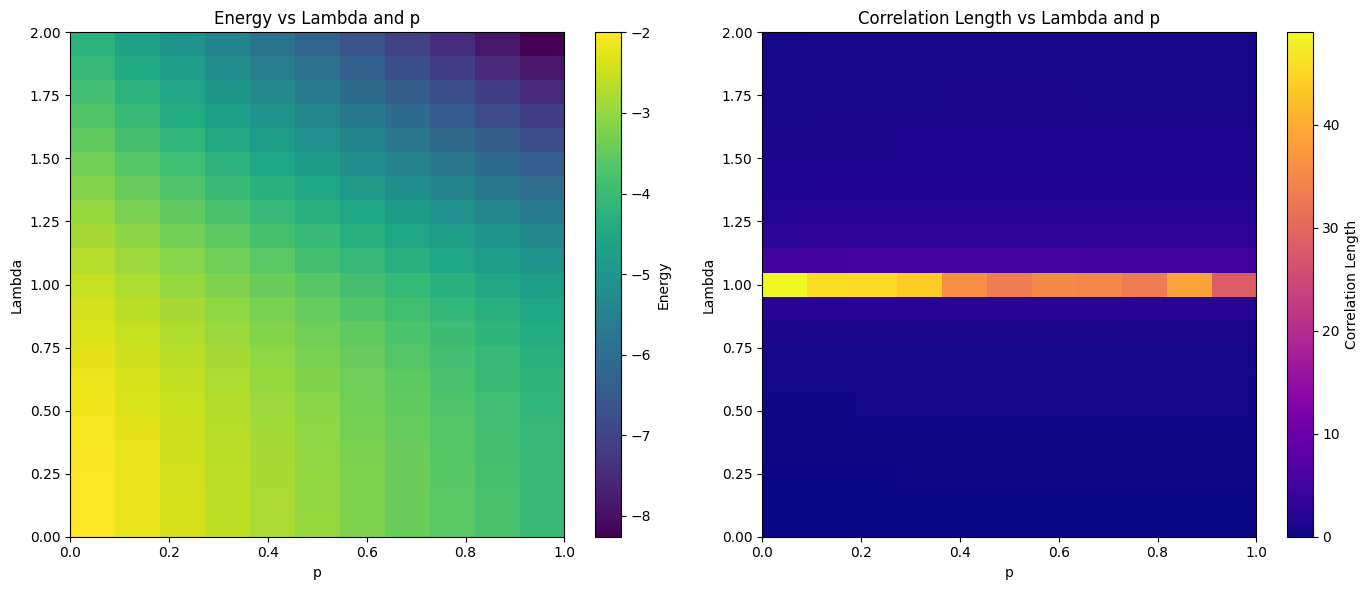

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 2D Colormap for Energy
c1 = ax1.imshow(E_16.T, extent=[p.min(), p.max(), lmbd.min(), lmbd.max()], origin='lower', aspect='auto', cmap='viridis')
ax1.set_title('Energy vs Lambda and p')
ax1.set_xlabel('p')
ax1.set_ylabel('Lambda')
fig.colorbar(c1, ax=ax1, orientation='vertical', label='Energy')

# 2D Colormap for Correlation Length
c2 = ax2.imshow(corr_lenght_16.T, extent=[p.min(), p.max(), lmbd.min(), lmbd.max()], origin='lower', aspect='auto', cmap='plasma')
ax2.set_title('Correlation Length vs Lambda and p')
ax2.set_xlabel('p')
ax2.set_ylabel('Lambda')
fig.colorbar(c2, ax=ax2, orientation='vertical', label='Correlation Length')

plt.tight_layout()
plt.show()


In [ ]:
''' Standard transverse-field Ising model with bond dimension D = 32 '''

spin = 0.5
D = 32

p = 0
lmbd = np.linspace(0,2,21)
E_p0_32 = np.zeros(len(lmbd))
corr_lenght_p0_32 = np.zeros(len(lmbd))

for i in range(len(lmbd)):
  M, psi = H_model(spin, lmbd[i], p)
  E_p0_32[i] = run_dmrg(M, psi, D, 10)
  corr_lenght_p0_32[i] = psi.correlation_length()


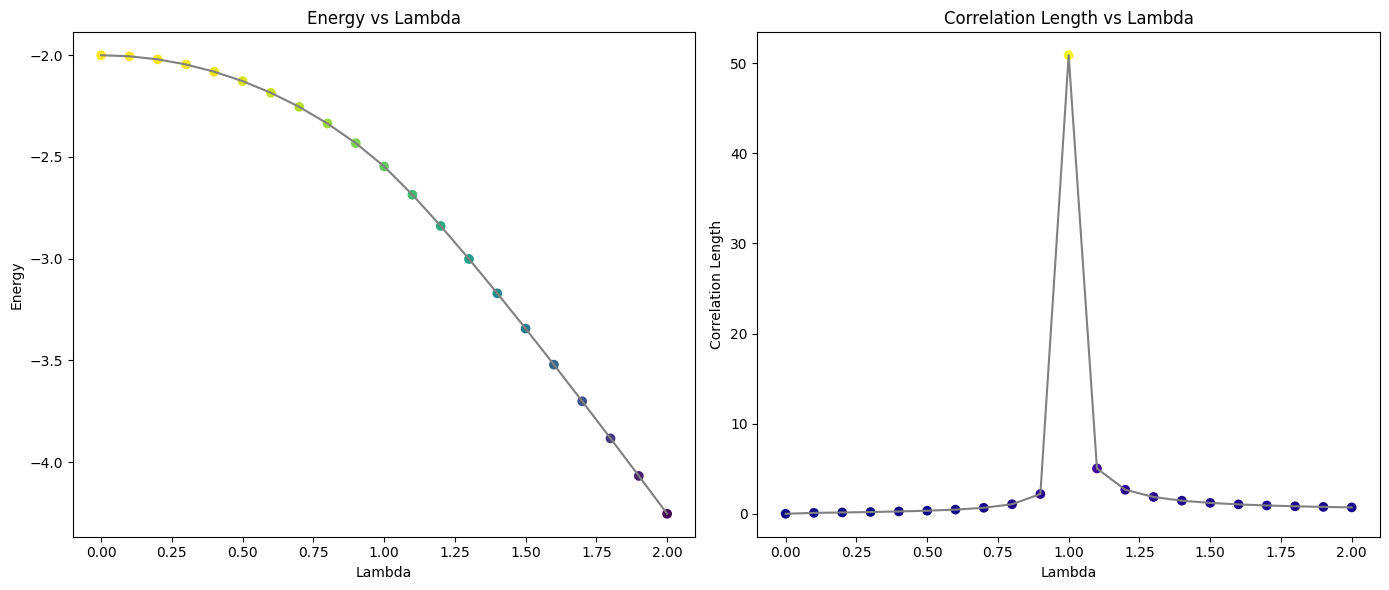

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Normalize the data for color mapping
norm_energy = plt.Normalize(E_p0_32.min(), E_p0_32.max())
norm_corr = plt.Normalize(corr_lenght_p0_32.min(), corr_lenght_p0_32.max())

# Plot Energy vs Lambda with viridis color palette
sc1 = ax1.scatter(lmbd, E_p0_32, c=E_p0_32, cmap='viridis', norm=norm_energy, marker='o')
ax1.plot(lmbd, E_p0_32, linestyle='-', color='gray')  # Add line connecting the dots
ax1.set_title('Energy vs Lambda')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Energy')
# fig.colorbar(sc1, ax=ax1, label='Energy')

# Plot Correlation Length vs Lambda with plasma color palette
sc2 = ax2.scatter(lmbd, corr_lenght_p0_32, c=corr_lenght_p0_32, cmap='plasma', norm=norm_corr, marker='o')
ax2.plot(lmbd, corr_lenght_p0_32, linestyle='-', color='gray')  # Add line connecting the dots
ax2.set_title('Correlation Length vs Lambda')
ax2.set_xlabel('Lambda')
ax2.set_ylabel('Correlation Length')
# fig.colorbar(sc2, ax=ax2, label='Correlation Length')

plt.tight_layout()
plt.show()


In [ ]:
''' Full Hamiltonian with bond dimension D = 32 '''

spin = 0.5
D = 32

p = np.linspace(0,1,11)
lmbd = np.linspace(0,2,21)
E_32 = np.zeros((len(p),len(lmbd)))
corr_lenght_32 = np.zeros((len(p),len(lmbd)))

for j in range(len(p)):
    print(f"Running DMRG for p = {p[j]}")
    for i in range(len(lmbd)):
        M, psi = H_model(spin, lmbd[i], p[j])
        E_32[j, i] = run_dmrg(M, psi, D, 10)
        corr_lenght_32[j, i] = psi.correlation_length()


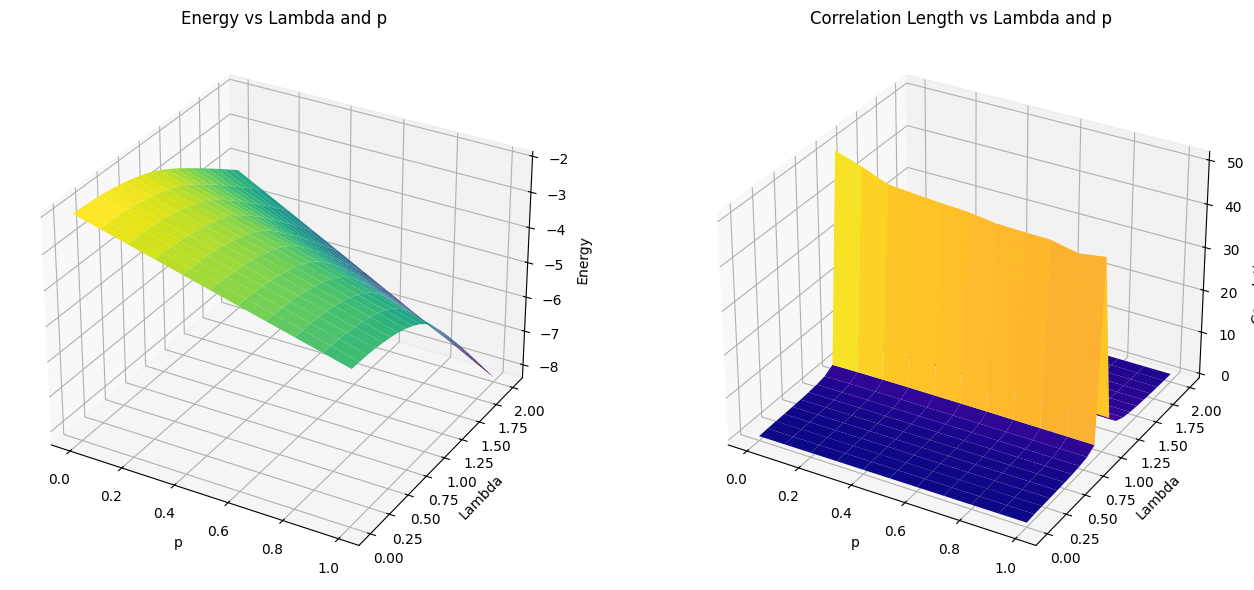

In [19]:
fig = plt.figure(figsize=(14, 6))

# 3D Plot for Energy
ax1 = fig.add_subplot(121, projection='3d')
P, L = np.meshgrid(p, lmbd)
ax1.plot_surface(P, L, E_32.T, cmap='viridis')
ax1.set_title('Energy vs Lambda and p')
ax1.set_xlabel('p')
ax1.set_ylabel('Lambda')
ax1.set_zlabel('Energy')

# 3D Plot for Correlation Length
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(P, L, corr_lenght_32.T, cmap='plasma')
ax2.set_title('Correlation Length vs Lambda and p')
ax2.set_xlabel('p')
ax2.set_ylabel('Lambda')
ax2.set_zlabel('Correlation Length')

plt.tight_layout()
plt.show()


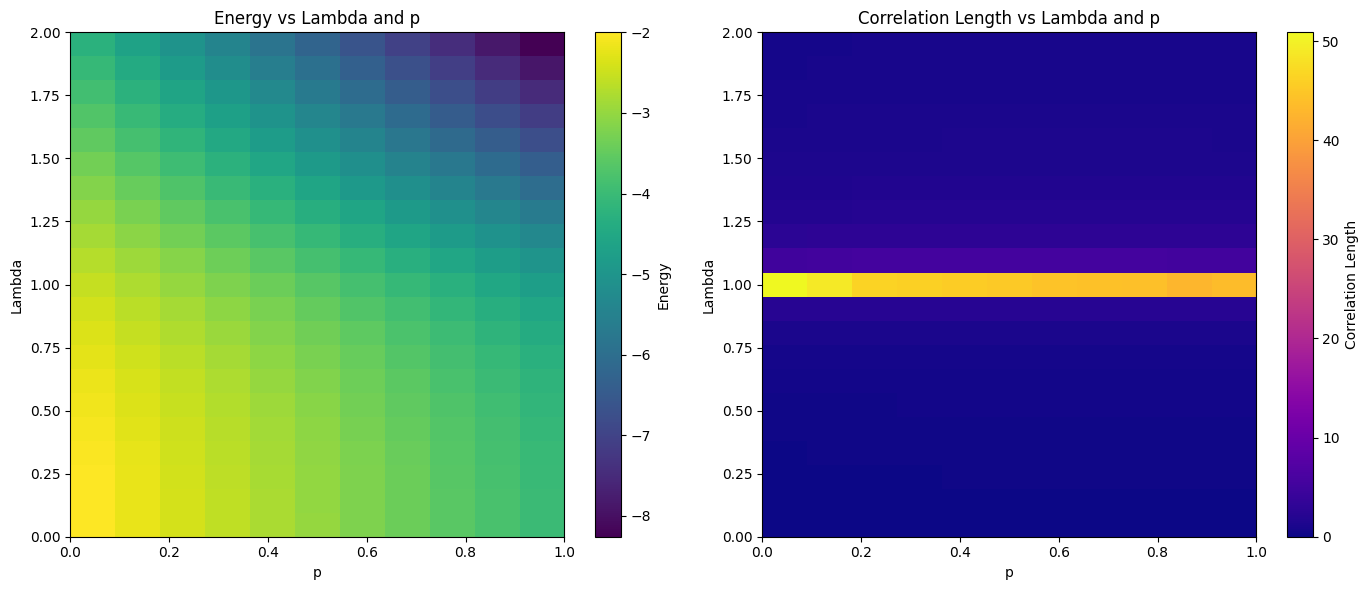

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 2D Colormap for Energy
c1 = ax1.imshow(E_32.T, extent=[p.min(), p.max(), lmbd.min(), lmbd.max()], origin='lower', aspect='auto', cmap='viridis')
ax1.set_title('Energy vs Lambda and p')
ax1.set_xlabel('p')
ax1.set_ylabel('Lambda')
fig.colorbar(c1, ax=ax1, orientation='vertical', label='Energy')

# 2D Colormap for Correlation Length
c2 = ax2.imshow(corr_lenght_32.T, extent=[p.min(), p.max(), lmbd.min(), lmbd.max()], origin='lower', aspect='auto', cmap='plasma')
ax2.set_title('Correlation Length vs Lambda and p')
ax2.set_xlabel('p')
ax2.set_ylabel('Lambda')
fig.colorbar(c2, ax=ax2, orientation='vertical', label='Correlation Length')

plt.tight_layout()
plt.show()


In [ ]:
Ds = [2, 4, 8, 16, 32, 64]
lambd_crit = 1
p_values = [0, 0.25, 0.5, 0.75, 1]

spin, L = 0.5, 2

# Initialize the entropy array with shape (len(p_values), len(Ds), 2)
entropy_p = np.zeros((len(p_values), len(Ds), 2))

for j, p in enumerate(p_values):
    for i in range(len(Ds)):
        print(f"Running DMRG for p = {p}, D = {Ds[i]}")
        M, psi = H_model(spin, lambd_crit, p)
        run_dmrg(M, psi, Ds[i], 1000)
        entropy_p[j, i] = psi.entanglement_entropy()


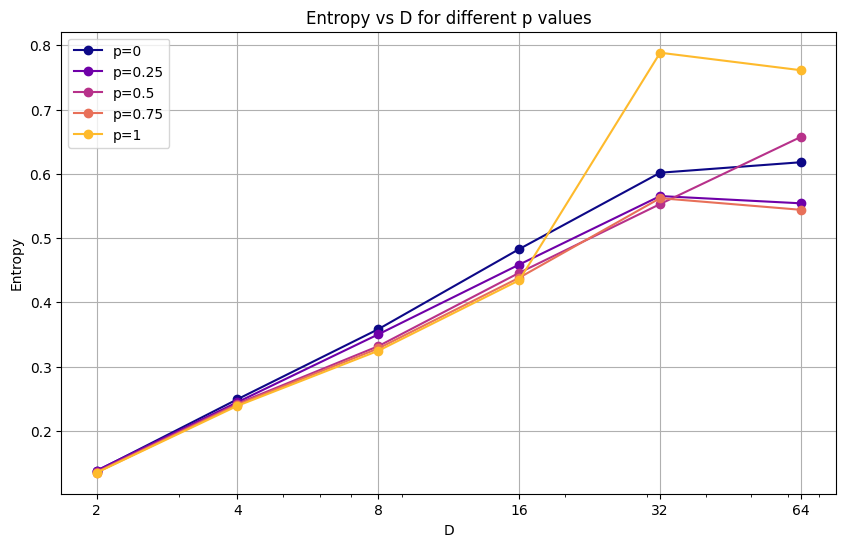

In [10]:
log_Ds = np.log(Ds)
colors = mpl.cm.plasma(np.linspace(0, 0.85, len(p_values)))

plt.figure(figsize=(10, 6))
for idx, p in enumerate(p_values):
    mean_entropy = np.mean(entropy_p[idx], axis=1)
    plt.plot(Ds, mean_entropy, marker='o', linestyle='-', color=colors[idx], label=f'p={p}')

plt.xscale('log')
plt.xticks(Ds, Ds)
plt.title('Entropy vs D for different p values')
plt.xlabel('D')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
Ds = [2,4,8,16,32,64]
p = 0

lmbd_values = np.linspace(0.9, 1.1, 21)
entropy_values_all_Ds = np.zeros((len(Ds), len(lmbd_values)))

for j, D in enumerate(Ds):
    print(f"Running DMRG for D = {D}")
    for i, lmbd in enumerate(lmbd_values):
        M, psi = H_model(spin, lmbd, p)
        run_dmrg(M, psi, D, 100)
        entropy_values_all_Ds[j, i] = psi.entanglement_entropy()[0]  # Assuming we want the entropy of the first site


In [58]:
# Saving variables with pickle

import pickle

# Save entropy_values, p_values, and lmbd_values to a pickle file
with open('entropy_D_l.pkl', 'wb') as f:
    pickle.dump((entropy_values_all_Ds, Ds, lmbd_values), f)

# Load the variables back from the pickle file
with open('entropy_D_l.pkl', 'rb') as f:
    entropy_values_all_Ds, Ds, lmbd_values = pickle.load(f)


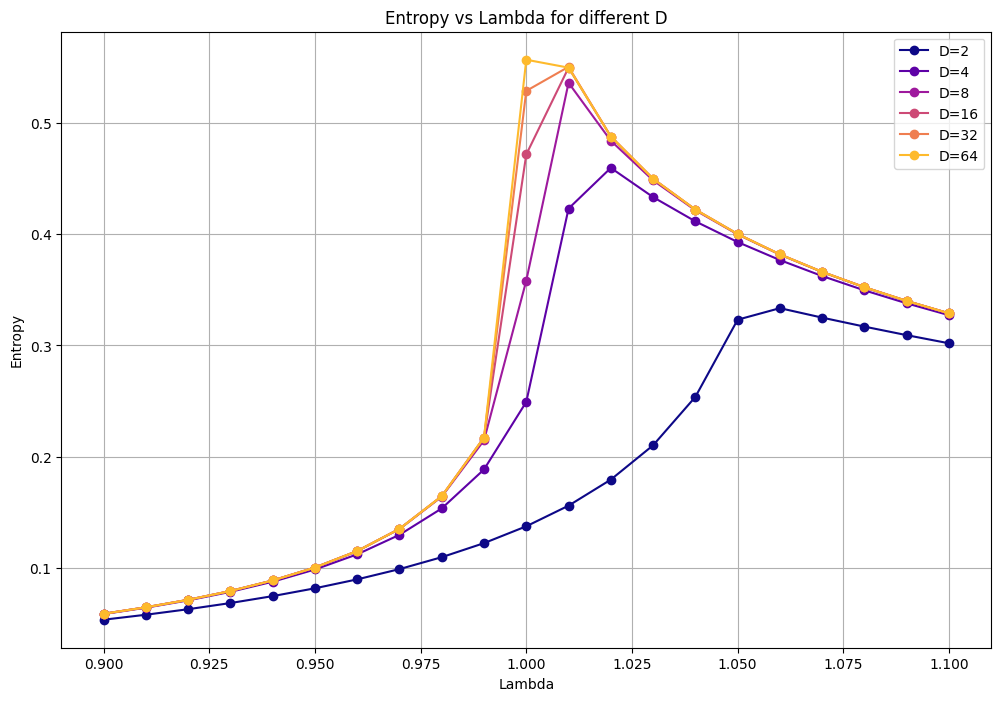

In [7]:
colors = mpl.cm.plasma(np.linspace(0, 0.85, len(Ds)))

plt.figure(figsize=(12, 8))
for j, D in enumerate(Ds):
    plt.plot(lmbd_values, entropy_values_all_Ds[j], marker='o', linestyle='-', color=colors[j], label=f'D={D}')
plt.title('Entropy vs Lambda for different D')
plt.xlabel('Lambda')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
spin = 0.5
D = 64

p_values = np.linspace(0, 1, 11)
lmbd_values = np.linspace(0.8, 1.2, 21)
entropy_values = np.zeros((len(p_values), len(lmbd_values)))

for j, p in enumerate(p_values):
    print(f"Running DMRG for p = {p}")
    for i, lmbd in enumerate(lmbd_values):
        M, psi = H_model(spin, lmbd, p)
        run_dmrg(M, psi, D, 100)
        entropy_values[j, i] = psi.entanglement_entropy()[0]  # Taking the entropy of the first site


In [ ]:
# Saving variables with pickle

import pickle

# Save entropy_values, p_values, and lmbd_values to a pickle file
with open('entropy_p_l.pkl', 'wb') as f:
    pickle.dump((entropy_values, p_values, lmbd_values), f)

# Load the variables back from the pickle file
with open('entropy_p_l.pkl', 'rb') as f:
    entropy_values, p_values, lmbd_values = pickle.load(f)


Text(0, 0.5, 'Lambda')

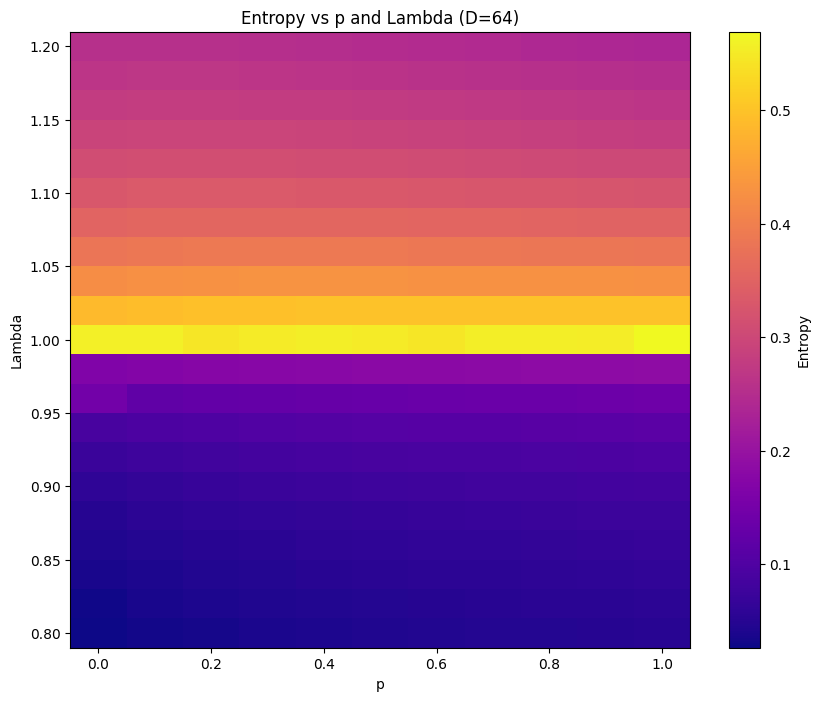

In [ ]:
# Assuming p_values, lmbd_values, and entropy_values are defined
P, L = np.meshgrid(p_values, lmbd_values)

fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(P, L, entropy_values.T, cmap='plasma', shading='auto')

# Add colorbar
fig.colorbar(c, ax=ax, label='Entropy')

# Labels and title
ax.set_title('Entropy vs p and Lambda (D=64)')
ax.set_xlabel('p')
ax.set_ylabel('Lambda')


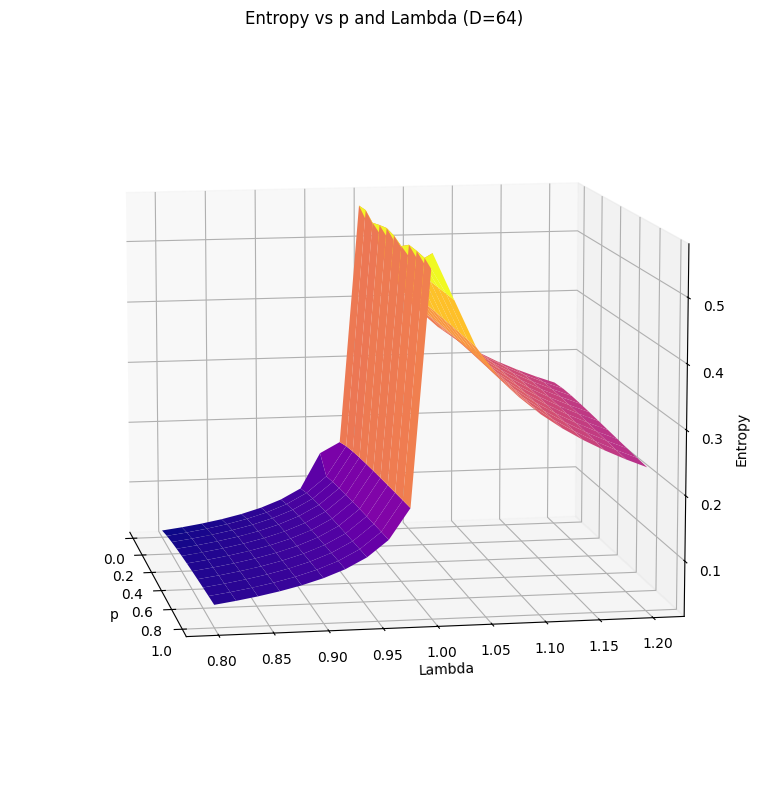

In [49]:
P, L = np.meshgrid(p_values, lmbd_values)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(P, L, entropy_values.T, cmap='plasma')
ax.set_title('Entropy vs p and Lambda (D=64)')
ax.set_xlabel('p')
ax.set_ylabel('Lambda')
ax.set_zlabel('Entropy')
plt.tight_layout()
ax.view_init(elev=10, azim=-10)
plt.show()


---
### III. OUT-OF-EQUILIBRIUM DYNAMICS

Using **TeNPy** [2,3], implement the following quantum quench protocol:

1. **Quench from a product state using the ITEBD algorithm**:

   (a) Initialize all spins in the $\left| + \right\rangle$ state (along x-axis).  

   (b) Evolve under the Hamiltonian with $p = 0.5$ and $\lambda = 1$ for time $t = 5$, using a maximum bond dimension $D = 100$.  

2. **Plot the following as functions of time:**  

   (a) Magnetization $\langle \sigma^x \rangle (t)$.  

   (b) Magnetization $\langle \sigma^z \rangle (t)$.  

   (c) Entanglement entropy of half the chain.  

   (d) Bond dimension $D$.  

   (e) Truncation error $\epsilon$.   

3. **Entanglement spectrum analysis:**  

   (a) Compute the entanglement spectrum $e_i = -\log(\lambda_i)$, where $\lambda_i$ are the eigenvalues of the reduced density matrix.  

   (b) Define gaps $\Delta_i = e_i - e_0$ for the 10 largest eigenvalues and plot both $\Delta_i$ and their ratios $\Delta_i / \Delta_1$ as functions of time.  


In [2]:
def run_tebd(M, psi, chi_max):

    tebd_params = {
        'N_steps': 1,
        'dt': 0.01,
        'order': 4,
        'trunc_params': {'chi_max': chi_max, 'svd_min': 1.e-12}
    }
    eng = tebd.TEBDEngine(psi, M, tebd_params)

    return eng

def measurement(eng, data):
    keys = ['t', 'entropy', 'Sx', 'Sz', 'trunc_err', 'max_bond_dim', 'psi']

    if data is None:
        data = dict([(k, []) for k in keys])

    data['t'].append(eng.evolved_time)
    data['entropy'].append(eng.psi.entanglement_entropy())

    magnetization_x = 0.0
    magnetization_z = 0.0

    for i in range(eng.psi.L):
        # Directly use the pre-defined expectation values
        magnetization_x += eng.psi.expectation_value(f"Sx{i}")
        magnetization_z += eng.psi.expectation_value(f"Sz{i}")

    data['Sx'].append(magnetization_x / eng.psi.L)
    data['Sz'].append(magnetization_z / eng.psi.L)

    data['trunc_err'].append(eng.trunc_err.eps)
    data['max_bond_dim'].append(max(eng.psi.chi))

    data['psi'].append(eng.psi.copy())

    return data


In [3]:
def H_model_switch(spin,lmbd,p):
  
    model_params = dict(L=2, S=spin, Jy=0, Jx=-4, hz=lmbd*2, hy=0, hx=0, Jzp=0, Jyp=0, Jxp=-p*4, Jz=-p*lmbd*4, bc_MPS ='infinite', conserve = 'None')
    M = SpinChainNNN(model_params)
    
    psi = MPS.from_lat_product_state(M.lat, [['up_0 up_1']])

    return M, psi


In [ ]:
''' TEBD with Z<->X, intial state on |up> <-> |+>, then swith again '''

spin = 0.5
p = 0.5
lmbd = 1.0
t = 5.0

D = 1
D_max = 100

M, psi = H_model_switch(spin, lmbd, p)

eng = run_tebd(M, psi, D_max)
data = measurement(eng, None)

while eng.evolved_time < 5.:
    eng.run()
    measurement(eng, data)

    if abs(eng.evolved_time - round(eng.evolved_time)) < 1e-3:
        print(eng.evolved_time)


1.0000000000000007
2.0000000000000013
2.99999999999998
3.9999999999999587
4.999999999999938


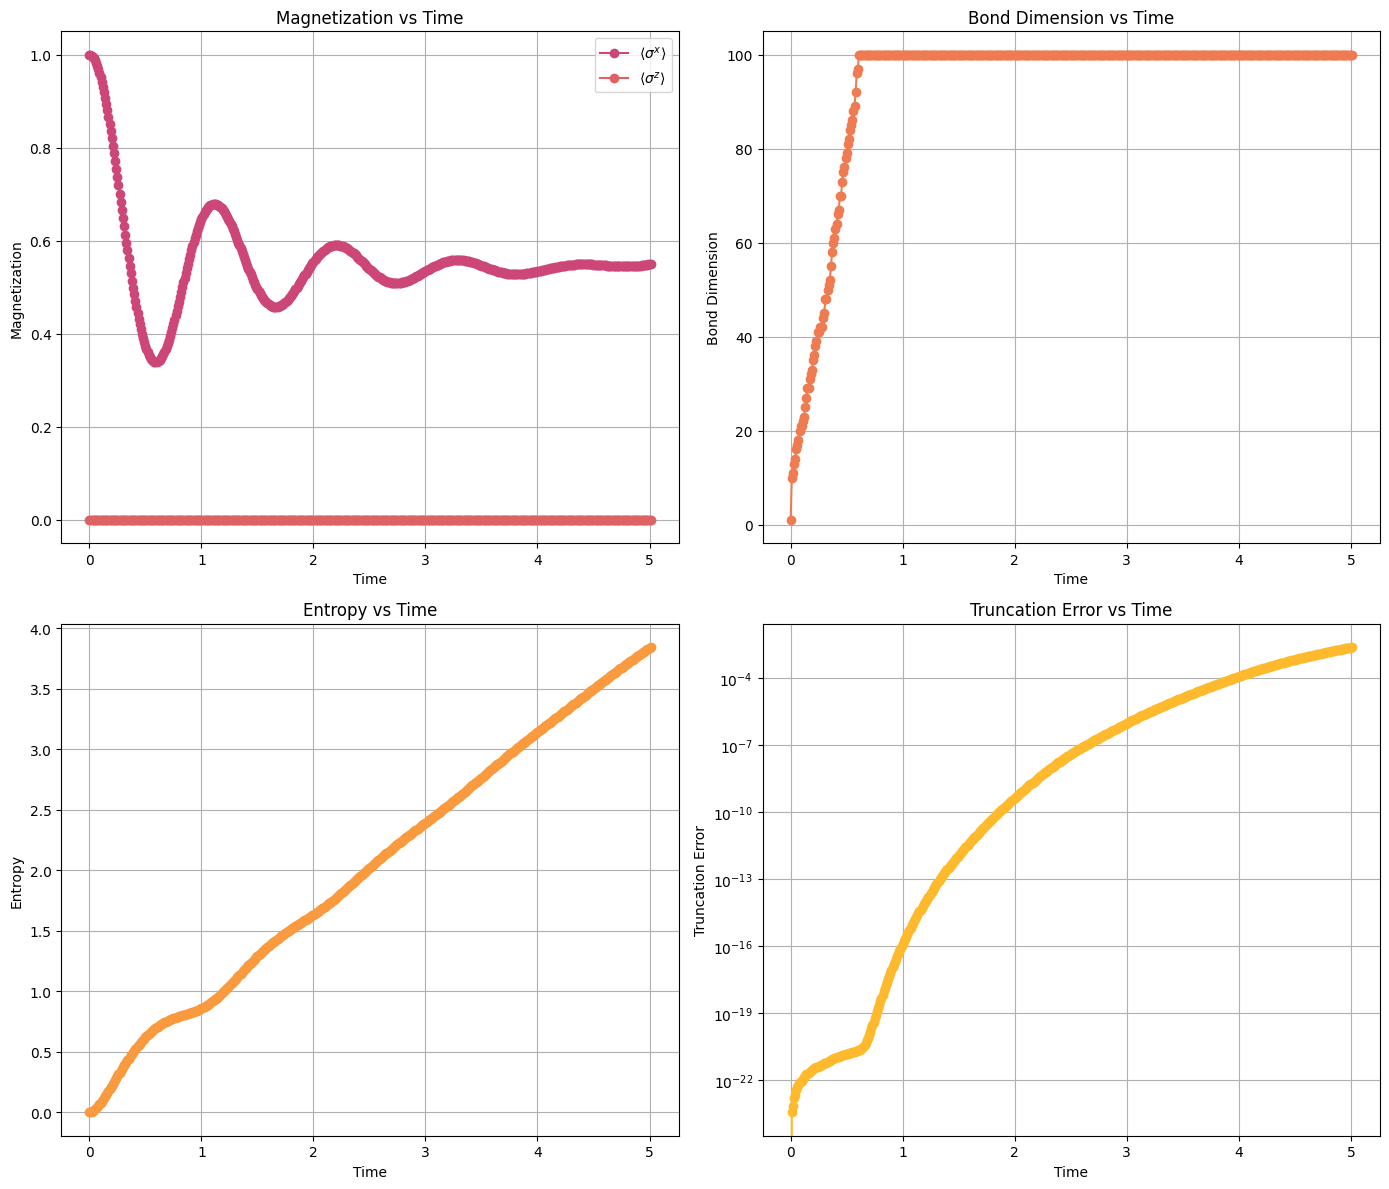

<Figure size 640x480 with 0 Axes>

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))

# Use plasma color palette
colors = mpl.cm.plasma(np.linspace(0.5, 0.85, 5))

# Plot Magnetization vs Time
ax1.plot(data['t'], [2*sx[0] for sx in data['Sz']], label=r'$\langle \sigma^x \rangle$', marker='o', linestyle='-', color=colors[0])
ax1.plot(data['t'], [2*sz[0] for sz in data['Sx']], label=r'$\langle \sigma^z \rangle$', marker='o', linestyle='-', color=colors[1])
ax1.set_title('Magnetization vs Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnetization')
ax1.legend()
ax1.grid(True)

# Plot Bond Dimension vs Time
ax2.plot(data['t'], data['max_bond_dim'], marker='o', linestyle='-', color=colors[2])
ax2.set_title('Bond Dimension vs Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Bond Dimension')
ax2.grid(True)

# Plot Entropy vs Time
ax3.plot(data['t'], [np.mean(ent) for ent in data['entropy']], marker='o', linestyle='-', color=colors[3])
ax3.set_title('Entropy vs Time')
ax3.set_xlabel('Time')
ax3.set_ylabel('Entropy')
ax3.grid(True)

# Plot log of Truncation Error vs Time
ax4.plot(data['t'], data['trunc_err'], marker='o', linestyle='-', color=colors[4])
ax4.set_title('Truncation Error vs Time')
ax4.set_xlabel('Time')
ax4.set_ylabel('Truncation Error')
ax4.set_yscale('log')
ax4.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Adjust layout
plt.tight_layout()
plt.show()


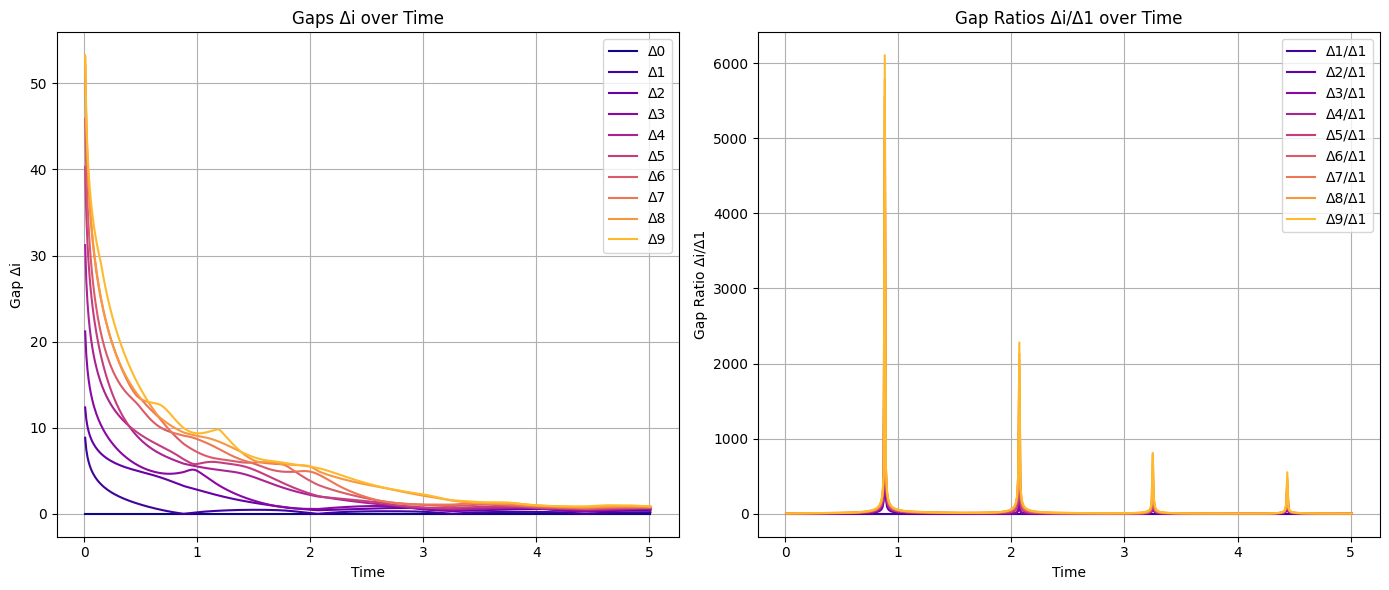

In [6]:
def entanglement_spectrum(psi):
    # Get the singular values from the entanglement spectrum at the specified bond
    singular_values = psi.entanglement_spectrum()[0]
    return singular_values

def compute_gaps(ent_spectrum):
    # Sort the entanglement spectrum in ascending order
    sorted_spectrum = np.sort(ent_spectrum)
    # Compute the gaps for the 10 lowest eigenvalues
    gaps = sorted_spectrum[:10] - sorted_spectrum[0]
    return gaps

def compute_gap_ratios(gaps):
    # Compute the ratios of the gaps
    gap_ratios = gaps / gaps[1]
    return gap_ratios

# Compute the entanglement spectrum, gaps, and gap ratios over time
entanglement_spectra = []
gaps_over_time = []
gap_ratios_over_time = []

for psi in data['psi'][1:]:
    spectrum = entanglement_spectrum(psi)
    entanglement_spectra.append(spectrum)

    gaps = compute_gaps(spectrum)
    gaps_over_time.append(gaps)
    
    gap_ratios = compute_gap_ratios(gaps)
    gap_ratios_over_time.append(gap_ratios)

# Convert lists to numpy arrays for easier plotting
gaps_over_time = np.array(gaps_over_time)
gap_ratios_over_time = np.array(gap_ratios_over_time)

# Plot the gaps and their ratios as functions of time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Use plasma color palette
colors = mpl.cm.plasma(np.linspace(0, 0.85, 10))

# Plot gaps
for i in range(10):
    ax1.plot(data['t'][1:], gaps_over_time[:, i], label=f'Δ{i}', color=colors[i])
ax1.set_title('Gaps Δi over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Gap Δi')
ax1.legend()
ax1.grid(True)

# Plot gap ratios
for i in range(1, 10):
    ax2.plot(data['t'][1:], gap_ratios_over_time[:, i], label=f'Δ{i}/Δ1', color=colors[i])
ax2.set_title('Gap Ratios Δi/Δ1 over Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Gap Ratio Δi/Δ1')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


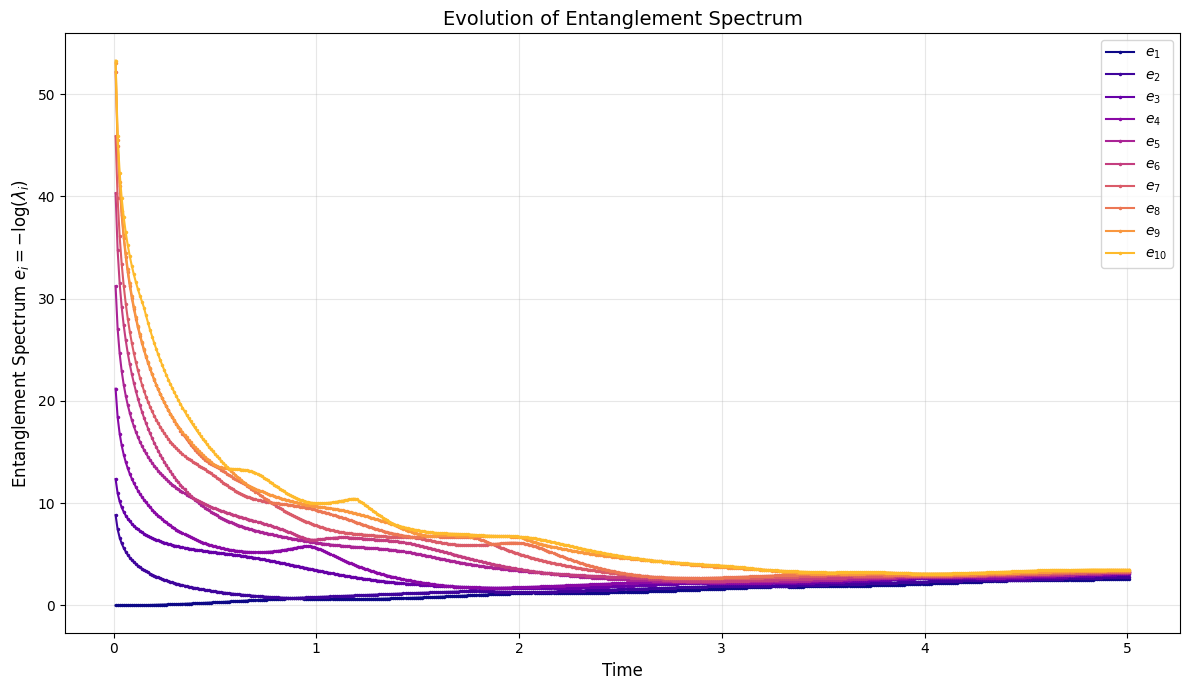

In [7]:
# Convert the list of entanglement spectra into a NumPy array for easier slicing
# Take only the first 10 eigenvalues from each spectrum
ent_spec_array = np.array([spectrum[:10] for spectrum in entanglement_spectra])

# Create a figure with a larger size for better visibility
plt.figure(figsize=(12, 7))
colors = mpl.cm.plasma(np.linspace(0, 0.85, 10))

# Plot the first 10 entanglement spectrum values over time
for i in range(10):
    plt.plot(data['t'][1:], ent_spec_array[:, i], 
             label=f'$e_{{{i+1}}}$', 
             color=colors[i],
             marker='.',
             markersize=3)

# Customize the plot
plt.xlabel('Time', fontsize=12)
plt.ylabel('Entanglement Spectrum $e_i = -\\log(\\lambda_i)$', fontsize=12)
plt.title('Evolution of Entanglement Spectrum', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()


---
### IV. SUMMARY

This assignment aims to deepen your understanding of quantum phase transitions and non-equilibrium dynamics using tensor network methods. Key takeaways include:

* Identifying quantum phases via correlation length scaling.
* Observing entanglement growth in quench dynamics.
* Understanding computational limitations imposed by bond dimension and truncation errors.

---

[1] F. C. Alcaraz, Physical Review B **94**, 115116 (2016).

[2] J. Hauschild and F. Pollmann, SciPost Physics Lecture Notes, 005 (2018).

[3] J. Hauschild, J. Unfried, S. Anand, B. Andrews, M. Bintz, U. Borla, S. Divic, M. Drescher, J. Geiger, M. Hefel, K. Hémery, W. Kadow, J. Kemp, N. Kirchner, V. S. Liu, G. Möller, D. Parker, M. Rader, A. Romen, S. Scalet, L. Schoonderwoerd, M. Schulz, T. Soejima, P. Thoma, Y. Wu, P. Zechmann, L. Zweng, R. S. K. Mong, M. P. Zaletel, and F. Pollmann, Tensor Network Python (TeNPy) version 1 (2024), arXiv:2408.02010.

[4] L. Tagliacozzo, Thiago. R. de Oliveira, S. Iblisdir, and J. I. Latorre, Physical Review B **78**, 024410 (2008).

[5] J. Surace, L. Tagliacozzo, and E. Tonni, Physical Review B **101**, 241107 (2020).